In [251]:
import os
import math
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from PIL import Image

In [252]:
class Digits(Dataset):
    def __init__(self, mode ='train', ROOT_FD='/workspace/nttrang2108/VHT/Neural_Compression/', transforms = None):
    
        if mode =='train':
            self.data = MNIST(root=ROOT_FD, transform=transforms, train=True, download=True)
            self.data = torch.utils.data.Subset(self.data, range(1000))
        elif mode == 'val':
            self.data = MNIST(root=ROOT_FD, transform=transforms, train=False, download=True)
            self.data = torch.utils.data.Subset(self.data, range(300))
        else:
            self.data = MNIST(root=ROOT_FD, transform=transforms, train=False, download=True)
            self.data = torch.utils.data.Subset(self.data, range(300, 400))
        
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # plt.imshow(self.data[idx][0], cmap='gray')
        # plt.show()
        img = np.array(self.data[idx][0])
        img = img.reshape(-1)
        img = img/255
        # to tensor
        img = torch.from_numpy(img).float()
    
        
        return img

In [253]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, A = False, **kwargs):
        super(CausalConv1d, self).__init__()

        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A  = A
        self.padding = (kernel_size - 1) * dilation + A * 1

        self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                                      kernel_size, stride = 1,
                                      padding = 0,
                                      dilation = dilation,
                                      **kwargs )
                                    
    def forward(self, x):
        x = torch.nn.functional.pad(x, (self.padding, 0))
        conv1d_out = self.conv1d(x)
        if self.A :
            return conv1d_out[:,:,: -1]
        else:
            return conv1d_out

In [254]:
class Quantizer(nn.Module):
    def __init__(self, input_dim, codebook_dim, temp = 1.e7):
        super(Quantizer, self).__init__()
        self.temp = temp
        self.input_dim = input_dim
        self.codebook_dim = codebook_dim
        self.codebook = nn.Parameter(torch.FloatTensor(1,self.codebook_dim, ).uniform_(-1/self.codebook_dim, 1/self.codebook_dim))

    def indices2codebook(self, indices_onehot):
        return torch.matmul(indices_onehot, self.codebook.t()).squeeze()

    def indices_to_onehot(self, inputs_shape, indices):
        indices_hard = torch.zeros(inputs_shape[0], inputs_shape[1], self.codebook_dim)
        indices_hard.scatter_(2, indices, 1)

    def forward(self, inputs):
        inputs_shape = inputs.shape
        inputs_repeat = inputs.unsqueeze(2).repeat(1,1,self.codebook_dim)
        distances = torch.exp(-torch.sqrt(torch.pow(inputs_repeat - self.codebook.unsqueeze(1), 2)))

        indices = torch.argmax(distances, dim = 2).unsqueeze(2)
        indices_hard = self.indices_to_onehot(inputs_shape = inputs_shape, indices = indices)

        indices_soft = torch.softmax(self.temp * distances, -1)
        quantized = self.indices2codebook(indices_onehot = indices_soft)

        return(indices_soft, indices_hard, quantized)

In [255]:
D = 784
C = 16
E = 16
M = 256
M_kernels = 32
kernel = 4
entropy_coding_type = 'arm'
lr = 1e-3
num_epochs = 24
max_patience = 50
beta = 1

In [256]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(D, M * 2), nn.BatchNorm1d(M * 2), nn.ReLU(),
                                     nn.Linear(M * 2, M), nn.BatchNorm1d(M), nn.ReLU(),
                                     nn.Linear(M, M // 2), nn.BatchNorm1d(M // 2), nn.ReLU(),
                                     nn.Linear(M // 2, C))
        
    def encode(self, x):
        h_e = self.encoder(x)
        return h_e
    
    def forward(self, x):
        return self.encode(x)

In [257]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(nn.Linear(C, M//2), nn.BatchNorm1d(M//2), nn.ReLU(),
                                     nn.Linear(M //2 , M), nn.BatchNorm1d(M), nn.ReLU(),
                                     nn.Linear(M, M * 2), nn.BatchNorm1d(M * 2), nn.ReLU(),
                                     nn.Linear(M * 2, D))
    
    def decode(self, z):
        h_d = self.decoder(z)
        return h_d

    def forward(self, z, x = None):
        x_rec = self.decode(z)
        return x_rec

In [258]:
class ARMEntropyCoding(nn.Module):
    def __init__(self, code_dim, codebook_dim):
        super(ARMEntropyCoding, self).__init__()
        self.code_dim = code_dim
        self.codebook_dim = codebook_dim
        self.arm_net = nn.Sequential(
            CausalConv1d(in_channels=1, out_channels=M_kernels, dilation=1, kernel_size=kernel, A=True, bias = True),
            nn.LeakyReLU(),
            CausalConv1d(in_channels=M_kernels, out_channels=M_kernels, dilation=1, kernel_size=kernel, A=False, bias = True),
            nn.LeakyReLU(),
            CausalConv1d(in_channels=M_kernels, out_channels=E, dilation=1, kernel_size=kernel, A=False, bias = True),
        )



    def f(self, x):
        h = self.arm_net(x.unsqueeze(1))
        h = h.permute(0, 2, 1)
        p = torch.softmax(h,2)

        return p
    
    def sample(self, quantizer = None, B =10):
        x_new = torch.zeros((B, self.code_dim))
        # print('Q_xnew:', x_new)

        for d in range(self.code_dim):
            p = self.f(x_new)
            # print('Q_p:', p)
            indx_d = torch.multinomial(p[:, d, :], num_samples = 1)
            codebook_value = quantizer.codebook[0, indx_d].squeeze()
            x_new[:, d] = codebook_value
        
        return x_new


    def forward(self, z, x):
        p = self.f(x)
        return -torch.sum(z * torch.log(p), 2)

In [259]:
class NeuralCompressor(nn.Module):
    def __init__(self, encoder, decoder, entropy_coding, quantizer, beta = 1., detaching = False):
        super(NeuralCompressor, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.entropy_coding = entropy_coding
        self.quantizer = quantizer

        self.beta = beta
        self.detaching = detaching

    def forward(self, x, reduction = 'avg'):
        z = self.encoder(x)
        quantizer_out = self.quantizer(z)
        x_rec = self.decoder(quantizer_out[2])
        Distortion = torch.mean(torch.pow(x - x_rec, 2), 1)
        Rate = torch.mean(self.entropy_coding(quantizer_out[0], quantizer_out[2]), 1)
        objective = Distortion + self.beta * Rate

        if reduction == 'sum':
            return objective.sum(), Distortion.sum(), Rate.sum()
        else:
            return objective.mean(), Distortion.mean(), Rate.mean()

In [260]:
def evaluation(test_loader, name = None, model_best = None, epoch = None):
    if model_best is None:
        model_best = torch.load(name + '.model')
    
    model_best.eval()
    loss = 0.
    distortion = 0.
    rate = 0.
    N = 0
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t, distortion_t, rate_t = model_best.forward(test_batch, reduction = 'sum')
        loss = loss + loss_t.item()
        distortion = distortion + distortion_t.item()
        rate = rate + rate_t.item()
        N  = N + test_batch.shape[0]
    
    loss = loss/N
    distortion = distortion/N
    rate = rate/N

    if epoch is None:
        print(f'Final LOSS: objective = {loss} (distortion = {distortion}, rate = {rate})')
    else:
        print(f'Epoch: {epoch}, objective val = {loss} (distortion = {distortion}, rate = {rate})')
    
    return loss, distortion, rate

def plot_curve(name, nll_val, metric_name = 'loss'):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth = '3')
    plt.xlabel('epochs')
    plt.ylabel(metric_name)
    plt.savefig(name + metric_name + '_val_curve.pdf', bbox_inches = 'tight')
    plt.close()



In [261]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    objective_loss_val = []
    objective_distortion_val = []
    objective_rate_val = []
    loss_best = 1000.
    patience = 0

    for e in range(num_epochs):
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss, _, _ = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph = True)
            optimizer.step()

        loss_val, distortion_val, rate_val = evaluation(val_loader, model_best = model, epoch = e)
        objective_loss_val.append(loss_val)
        objective_rate_val.append(rate_val)
        objective_distortion_val.append(distortion_val)

        if e == 0:
            print('=======SAVE=====')
            torch.save(model, name + '.model')
            loss_best = loss_val
        else:
            if loss_val < loss_best:
                print('=====SAVE====')
                torch.save(model, name + '.model')
                loss_best = loss_val
                patience = 0

            else:
                patience = patience + 1
        

        if patience > max_patience:
            break
    
    objective_loss_val = np.asarray(objective_loss_val)
    objective_rate_val = np.asarray(objective_rate_val)
    objective_distortion_val = np.asarray(objective_distortion_val)

    return  objective_loss_val, objective_distortion_val, objective_rate_val

In [262]:
train_data = Digits(mode = 'train')
val_data = Digits(mode = 'val')
test_data = Digits(mode = 'test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [263]:
result_dir = '/workspace/nttrang2108/VHT/Neural_Compression/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'neural_compressor_' + entropy_coding_type + '_C_' + str(C) + '_E_' + str(E)

In [264]:
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(input_dim=C, codebook_dim=E)
entropy_coding = ARMEntropyCoding(code_dim=C, codebook_dim=E)

model = NeuralCompressor(encoder=encoder, decoder=decoder, entropy_coding=entropy_coding, quantizer=quantizer, beta=beta )

In [265]:
entropy_coding.eval()

ARMEntropyCoding(
  (arm_net): Sequential(
    (0): CausalConv1d(
      (conv1d): Conv1d(1, 32, kernel_size=(4,), stride=(1,))
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): CausalConv1d(
      (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,))
    )
    (3): LeakyReLU(negative_slope=0.01)
    (4): CausalConv1d(
      (conv1d): Conv1d(32, 16, kernel_size=(4,), stride=(1,))
    )
  )
)

In [266]:
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr = lr)


In [267]:
objective_loss_val, objective_distortion_val, objective_rate_val = training(name = result_dir + name, max_patience= max_patience, num_epochs=num_epochs,
                                                                            optimizer = optimizer, training_loader = training_loader, model = model,
                                                                            val_loader = val_loader)

Epoch: 0, objective val = 2.575940882364909 (distortion = 0.08497881571451824, rate = 2.490962168375651)
=======SAVE=====
Epoch: 1, objective val = 1.8048992156982422 (distortion = 0.08250655174255371, rate = 1.7223926798502605)
=====SAVE====
Epoch: 2, objective val = 1.4671337509155273 (distortion = 0.07654765526453654, rate = 1.3905860137939454)
=====SAVE====
Epoch: 3, objective val = 1.3808867899576822 (distortion = 0.06998313744862875, rate = 1.3109036509195964)
=====SAVE====
Epoch: 4, objective val = 1.3504827880859376 (distortion = 0.06885722796122233, rate = 1.2816256205240886)
=====SAVE====
Epoch: 5, objective val = 1.3306076939900715 (distortion = 0.06882429838180543, rate = 1.2617834218343098)
=====SAVE====
Epoch: 6, objective val = 1.3176715723673502 (distortion = 0.06749308983484904, rate = 1.250178451538086)
=====SAVE====
Epoch: 7, objective val = 1.2571490987141927 (distortion = 0.06608874559402465, rate = 1.1910603332519532)
=====SAVE====
Epoch: 8, objective val = 1.2962

In [268]:
test_loss, test_distortion, tess_rate = evaluation(name = result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss_.txt', "w")
f.write(str(test_loss) + ',' + str(test_distortion) + ',' +str(tess_rate))
f.close()

plot_curve(result_dir + name +'_objective_', objective_loss_val, metric_name='objective')
plot_curve(result_dir + name +'_distortion_', objective_distortion_val, metric_name='distortion')
plot_curve(result_dir + name +'_rate_', objective_rate_val, metric_name='rate')

Final LOSS: objective = 1.1862716674804688 (distortion = 0.05913192987442017, rate = 1.1271397399902343)


In [269]:
test_data = Digits(mode = 'test')

torch.Size([4, 784])


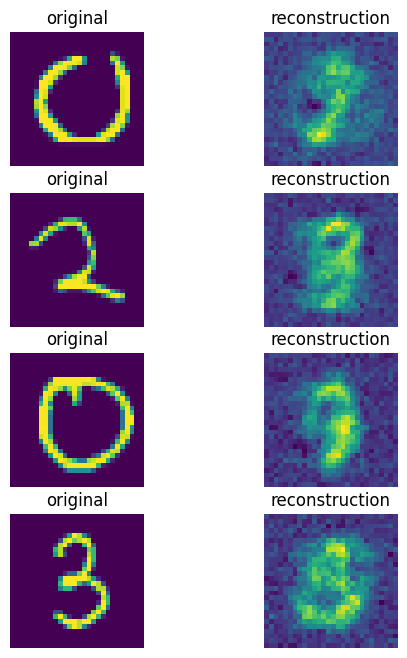

In [270]:
IMG_IDs = [80, 87, 5, 10]
z_sampled = model.entropy_coding.sample(quantizer=model.quantizer, B = 9)
x_sampled = model.decoder(z_sampled)

x_real = []
# stack to tensor
for i in IMG_IDs:
    x_real.append(test_data.__getitem__(i))
x_real = torch.stack(x_real, dim=0)
print(x_real.shape)
    
x_encoder = model.encoder(x_real)
# print(x_encoder)
# print("-----", model.quantizer(model.encoder(x_real)))
x_rec = model.decoder(model.quantizer(model.encoder(x_real))[-1])

fig, axs = plt.subplots(4, 2, figsize=(6, 8))
i = 0
for i in range(len(IMG_IDs)):
    axs[i,0].imshow(x_real[i].reshape(28,28).detach().numpy())
    axs[i,0].set_title('original')
    axs[i,0].axis('off')
    
    axs[i,1].imshow(x_rec[i].reshape(28,28).detach().numpy())
    axs[i,1].set_title('reconstruction')
    axs[i,1].axis('off')


In [271]:
x_sampled.size()

torch.Size([9, 784])

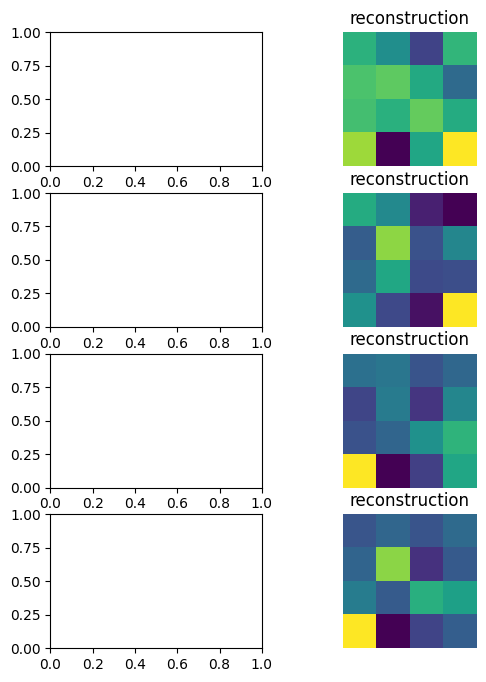

In [277]:
x_encoder = model.encoder(x_real)
fig, axs = plt.subplots(4, 2, figsize=(6, 8))
for i in range(len(IMG_IDs)):
    axs[i,1].imshow(x_encoder[i].reshape(4,4).detach().numpy())
    axs[i,1].set_title('reconstruction')
    axs[i,1].axis('off')